In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import statistics
import tqdm

from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
#from yellowbrick.model_selection import FeatureImportances
import matplotlib.gridspec as gridspec
#from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from sklearn.pipeline import Pipeline
from collections import defaultdict
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Shortcut to duplicate current line

In [2]:
%%javascript

Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('ctrl-shift-d', {
    help : 'Duplicate current line',
    help_index : 'zz',
    handler: function(env) {
        var cm=env.notebook.get_selected_cell().code_mirror;
        // get a position of a current cursor in a current cell
        var current_cursor = cm.doc.getCursor();

        // read a content from a line where is the current cursor
        var line_content = cm.doc.getLine(current_cursor.line);
        cm.execCommand('goLineEnd');
        cm.execCommand('newlineAndIndent');
        cm.execCommand('indentLess');
        cm.doc.replaceSelection(line_content);
        cm.doc.setCursor(current_cursor.line + 1, current_cursor.ch);
        return false;
    }}
);


<IPython.core.display.Javascript object>

In [3]:
with open('/home/nick/Documents/data/select_cols.p', 'rb') as read_file:
    selected_columns = pickle.load(read_file)

TW = "training wheels" dataset, sample of 50,000 to permit more experimentation with modelling on a limited timeline

In [4]:
selected_columns
tw = selected_columns.sample(50000)
ttw = selected_columns.sample(1000)
tttw = selected_columns.sample(50)

In [5]:
tw.head()

,UHRSWORK,OCC,DEGFIELDD,EDUC,WKSWORK2,VALUEH,OWNCOST,DEGFIELD,EDUCD,AGE,...,WRKLSTWK,PWMET13,REGION,EMPSTATD,WORKEDYR,CBPERNUM,PWMET13ERR,YNGCH,BEDROOMS,>50K
3142885,0.0,0.0,0.0,6.0,0.0,120000.0,209.0,0.0,65.0,61.0,...,3.0,0.0,31.0,30.0,1.0,2.0,0.0,99.0,4.0,0.0
2424001,0.0,4230.0,0.0,5.0,0.0,140000.0,806.0,0.0,50.0,17.0,...,3.0,0.0,12.0,30.0,2.0,3.0,0.0,99.0,5.0,0.0
1469564,0.0,0.0,0.0,6.0,0.0,70000.0,574.0,0.0,63.0,69.0,...,1.0,0.0,21.0,30.0,1.0,1.0,0.0,99.0,4.0,0.0
1543513,30.0,4110.0,0.0,6.0,6.0,200000.0,346.0,0.0,61.0,61.0,...,2.0,0.0,21.0,10.0,3.0,2.0,0.0,99.0,2.0,0.0
2020933,40.0,530.0,2300.0,10.0,6.0,480000.0,7742.0,23.0,101.0,44.0,...,2.0,35620.0,12.0,10.0,3.0,2.0,2.0,12.0,5.0,1.0


In [6]:
X, Xs, y, ys = selected_columns.drop(columns=['>50K', 'YRMARR', 'PWTYPE', 'BPLD', 'DEGFIELDD', 'EDUCD', 'PWMET13', 'BIRTHYR', 'SLWT', 'BPLD', 'RELATED', 'ANCESTR1D', 'EMPSTATD', 'PWMET13ERR', 'COUNTYICP']), tw.drop(columns=['>50K', 'YRMARR', 'PWTYPE', 'BPLD', 'DEGFIELDD', 'EDUCD', 'PWMET13', 'BIRTHYR', 'SLWT', 'BPLD', 'RELATED', 'ANCESTR1D', 'EMPSTATD', 'PWMET13ERR', 'COUNTYICP']), selected_columns.filter(['>50K']), tw.filter(['>50K'])

X = all features (57)  ,
    Xs = all features on tw (sampled) dataset

y = target (income above or below 50k)  ,
    ys = sampled target
    
Z = small selection of features (8)  ,
    Zs = sampled selected features

In [7]:
Z = selected_columns.filter(['EDUC', 'UHRSWORK', 'OCC', 'VALUEH', 'DEGFIELD', 'AGE', 'SEX', 'RACE', 'TRANWORK'])
Zs = tw.filter(['EDUC', 'UHRSWORK', 'OCC', 'VALUEH', 'DEGFIELD', 'AGE', 'SEX', 'RACE', 'TRANWORK'])

In [8]:
categorical_features = ['EDUC', 'DEGFIELD', 'SEX', 'OCC']
continuous_features = ['UHRSWORK', 'VALUEH', 'AGE', 'TRANWORK']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, test_size=0.2, random_state=42)

train_df = X_train.copy()
train_df['$$$'] = y_train

Z_train, Z_test, q_train, q_test = train_test_split(Z, y, test_size=0.2, random_state=42)
Zs_train, Zs_test, qs_train, qs_test = train_test_split(Zs, ys, test_size=0.2, random_state=42)

In [10]:
std = StandardScaler()
X_train_scaled = std.fit_transform(X_train)
Xs_train_scaled = std.fit_transform(Xs_train)

Z_train_scaled = std.fit_transform(Z_train)
Zs_train_scaled = std.fit_transform(Zs_train)

len(Xs_train)

40000

## KNN With regular X nonscaled
Full dataset, takes too long for quick testing. Save for final product (although hardly any difference)

In [11]:
# knn = KNeighborsClassifier(n_neighbors=5)
# knn.fit(X_train, y_train)
# print("The score for kNN is")
# print("Training: {:6.2f}%".format(100*knn.score(X_train, y_train)))
# print("Test set: {:6.2f}%".format(100*knn.score(X_test, y_test)))

## KNN with Xs

In [101]:
for n in range(1,20):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(Xs_train, ys_train)
    print("The score for kNN with {} neighbors is".format(n))
    print("Training: {:6.2f}%".format(100*knn.score(Xs_train, ys_train)))
    print("Test set: {:6.2f}%".format(100*knn.score(Xs_test, ys_test)))

<ipython-input-101-cb6574c9b928>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Xs_train, ys_train)


The score for kNN with 1 neighbors is
Training: 100.00%
Test set:  60.12%
The score for kNN with 2 neighbors is


<ipython-input-101-cb6574c9b928>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Xs_train, ys_train)


Training:  80.12%
Test set:  65.73%
The score for kNN with 3 neighbors is


<ipython-input-101-cb6574c9b928>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Xs_train, ys_train)


Training:  80.03%
Test set:  62.77%
The score for kNN with 4 neighbors is


<ipython-input-101-cb6574c9b928>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Xs_train, ys_train)


Training:  75.55%
Test set:  66.25%
The score for kNN with 5 neighbors is


<ipython-input-101-cb6574c9b928>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Xs_train, ys_train)


Training:  75.75%
Test set:  64.41%
The score for kNN with 6 neighbors is


<ipython-input-101-cb6574c9b928>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Xs_train, ys_train)


Training:  73.57%
Test set:  66.47%
The score for kNN with 7 neighbors is


<ipython-input-101-cb6574c9b928>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Xs_train, ys_train)


Training:  73.64%
Test set:  64.90%
The score for kNN with 8 neighbors is


<ipython-input-101-cb6574c9b928>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Xs_train, ys_train)


Training:  72.42%
Test set:  66.85%
The score for kNN with 9 neighbors is


<ipython-input-101-cb6574c9b928>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Xs_train, ys_train)


Training:  72.69%
Test set:  65.81%
The score for kNN with 10 neighbors is


<ipython-input-101-cb6574c9b928>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Xs_train, ys_train)


Training:  71.84%
Test set:  67.18%
The score for kNN with 11 neighbors is


<ipython-input-101-cb6574c9b928>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Xs_train, ys_train)


Training:  72.18%
Test set:  66.41%
The score for kNN with 12 neighbors is


<ipython-input-101-cb6574c9b928>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Xs_train, ys_train)


Training:  71.58%
Test set:  67.19%
The score for kNN with 13 neighbors is


<ipython-input-101-cb6574c9b928>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Xs_train, ys_train)


Training:  71.66%
Test set:  66.33%
The score for kNN with 14 neighbors is


<ipython-input-101-cb6574c9b928>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Xs_train, ys_train)


Training:  71.17%
Test set:  67.12%
The score for kNN with 15 neighbors is


<ipython-input-101-cb6574c9b928>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Xs_train, ys_train)


Training:  71.30%
Test set:  66.89%
The score for kNN with 16 neighbors is


<ipython-input-101-cb6574c9b928>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Xs_train, ys_train)


Training:  70.82%
Test set:  67.35%
The score for kNN with 17 neighbors is


<ipython-input-101-cb6574c9b928>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Xs_train, ys_train)


Training:  70.88%
Test set:  67.10%
The score for kNN with 18 neighbors is


<ipython-input-101-cb6574c9b928>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Xs_train, ys_train)


Training:  70.53%
Test set:  67.39%
The score for kNN with 19 neighbors is


<ipython-input-101-cb6574c9b928>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Xs_train, ys_train)


Training:  70.68%
Test set:  67.56%


## KNN with scaled Xs 

\~ takes forever for some reason \~

In [109]:
for n in range(1,20): 
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(Xs_train_scaled, ys_train)
    print("The score for kNN with {} neighbors is".format(n))
    print("Training: {:6.2f}%".format(100*knn.score(Xs_train_scaled[:1000], ys_train[:1000])))
    print("Test set: {:6.2f}%".format(100*knn.score(Xs_test[:1000], ys_test[:1000])))

<ipython-input-109-5b12fa5ba297>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Xs_train_scaled, ys_train)


The score for kNN with 1 neighbors is
Training: 100.00%
Test set:  69.60%


<ipython-input-109-5b12fa5ba297>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Xs_train_scaled, ys_train)


The score for kNN with 2 neighbors is
Training:  86.40%
Test set:  69.80%
The score for kNN with 3 neighbors is


<ipython-input-109-5b12fa5ba297>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Xs_train_scaled, ys_train)


Training:  85.10%
Test set:  68.50%


<ipython-input-109-5b12fa5ba297>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Xs_train_scaled, ys_train)


The score for kNN with 4 neighbors is
Training:  81.80%
Test set:  69.70%


<ipython-input-109-5b12fa5ba297>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Xs_train_scaled, ys_train)


The score for kNN with 5 neighbors is
Training:  81.70%
Test set:  68.90%


<ipython-input-109-5b12fa5ba297>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Xs_train_scaled, ys_train)


The score for kNN with 6 neighbors is
Training:  81.70%
Test set:  69.70%


<ipython-input-109-5b12fa5ba297>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Xs_train_scaled, ys_train)


The score for kNN with 7 neighbors is
Training:  82.50%
Test set:  69.30%


<ipython-input-109-5b12fa5ba297>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Xs_train_scaled, ys_train)


The score for kNN with 8 neighbors is
Training:  81.10%
Test set:  69.60%
The score for kNN with 9 neighbors is


<ipython-input-109-5b12fa5ba297>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Xs_train_scaled, ys_train)


Training:  81.30%
Test set:  69.10%
The score for kNN with 10 neighbors is


<ipython-input-109-5b12fa5ba297>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Xs_train_scaled, ys_train)


Training:  81.00%
Test set:  69.10%


<ipython-input-109-5b12fa5ba297>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Xs_train_scaled, ys_train)


The score for kNN with 11 neighbors is
Training:  80.90%
Test set:  68.60%


<ipython-input-109-5b12fa5ba297>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Xs_train_scaled, ys_train)


The score for kNN with 12 neighbors is
Training:  81.00%
Test set:  68.80%
The score for kNN with 13 neighbors is


<ipython-input-109-5b12fa5ba297>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Xs_train_scaled, ys_train)


Training:  81.70%
Test set:  68.70%


<ipython-input-109-5b12fa5ba297>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Xs_train_scaled, ys_train)


The score for kNN with 14 neighbors is
Training:  81.10%
Test set:  69.70%


<ipython-input-109-5b12fa5ba297>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Xs_train_scaled, ys_train)


The score for kNN with 15 neighbors is
Training:  81.40%
Test set:  68.50%


<ipython-input-109-5b12fa5ba297>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Xs_train_scaled, ys_train)


The score for kNN with 16 neighbors is
Training:  80.90%
Test set:  68.70%


<ipython-input-109-5b12fa5ba297>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Xs_train_scaled, ys_train)


The score for kNN with 17 neighbors is
Training:  81.50%
Test set:  68.80%


<ipython-input-109-5b12fa5ba297>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Xs_train_scaled, ys_train)


The score for kNN with 18 neighbors is
Training:  80.40%
Test set:  68.90%


<ipython-input-109-5b12fa5ba297>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Xs_train_scaled, ys_train)


The score for kNN with 19 neighbors is
Training:  80.60%
Test set:  68.70%


## KNN with small feature set sample (Zs) scaled

In [104]:
for n in range(1,20):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(Zs_train_scaled, qs_train)
    print("The score for kNN with {} neighbors is".format(n))
    print("Training: {:6.2f}%".format(100*knn.score(Zs_train_scaled, qs_train)))
    print("Test set: {:6.2f}%".format(100*knn.score(Zs_test, qs_test)))

<ipython-input-104-b894698faa20>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Zs_train_scaled, qs_train)


The score for kNN with 1 neighbors is
Training:  99.48%
Test set:  53.94%


<ipython-input-104-b894698faa20>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Zs_train_scaled, qs_train)


The score for kNN with 2 neighbors is
Training:  87.68%
Test set:  68.67%


<ipython-input-104-b894698faa20>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Zs_train_scaled, qs_train)


The score for kNN with 3 neighbors is
Training:  87.62%
Test set:  47.73%
The score for kNN with 4 neighbors is


<ipython-input-104-b894698faa20>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Zs_train_scaled, qs_train)


Training:  85.34%
Test set:  48.05%
The score for kNN with 5 neighbors is


<ipython-input-104-b894698faa20>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Zs_train_scaled, qs_train)


Training:  85.23%
Test set:  47.76%
The score for kNN with 6 neighbors is


<ipython-input-104-b894698faa20>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Zs_train_scaled, qs_train)


Training:  84.33%
Test set:  47.89%
The score for kNN with 7 neighbors is


<ipython-input-104-b894698faa20>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Zs_train_scaled, qs_train)


Training:  84.28%
Test set:  48.10%


<ipython-input-104-b894698faa20>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Zs_train_scaled, qs_train)


The score for kNN with 8 neighbors is
Training:  83.94%
Test set:  47.87%


<ipython-input-104-b894698faa20>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Zs_train_scaled, qs_train)


The score for kNN with 9 neighbors is
Training:  83.74%
Test set:  47.97%
The score for kNN with 10 neighbors is


<ipython-input-104-b894698faa20>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Zs_train_scaled, qs_train)


Training:  83.42%
Test set:  60.58%
The score for kNN with 11 neighbors is


<ipython-input-104-b894698faa20>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Zs_train_scaled, qs_train)


Training:  83.22%
Test set:  49.12%
The score for kNN with 12 neighbors is


<ipython-input-104-b894698faa20>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Zs_train_scaled, qs_train)


Training:  83.14%
Test set:  48.56%
The score for kNN with 13 neighbors is


<ipython-input-104-b894698faa20>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Zs_train_scaled, qs_train)


Training:  83.06%
Test set:  49.06%
The score for kNN with 14 neighbors is


<ipython-input-104-b894698faa20>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Zs_train_scaled, qs_train)


Training:  82.89%
Test set:  48.09%
The score for kNN with 15 neighbors is


<ipython-input-104-b894698faa20>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Zs_train_scaled, qs_train)


Training:  82.83%
Test set:  48.24%
The score for kNN with 16 neighbors is


<ipython-input-104-b894698faa20>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Zs_train_scaled, qs_train)


Training:  82.66%
Test set:  50.54%
The score for kNN with 17 neighbors is


<ipython-input-104-b894698faa20>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Zs_train_scaled, qs_train)


Training:  82.66%
Test set:  37.88%
The score for kNN with 18 neighbors is


<ipython-input-104-b894698faa20>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Zs_train_scaled, qs_train)


Training:  82.53%
Test set:  50.88%
The score for kNN with 19 neighbors is


<ipython-input-104-b894698faa20>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Zs_train_scaled, qs_train)


Training:  82.48%
Test set:  53.02%


## KNN with small feature set Zs unscaled

### \~\~\~ *one of the best tried yet* \~\~\~

In [106]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(Zs_train, qs_train)
print("Training: {:6.2f}%".format(100*knn.score(Zs_train, qs_train)))
print("Test set: {:6.2f}%".format(100*knn.score(Zs_test, qs_test)))

<ipython-input-106-b876eb494d7b>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Zs_train, qs_train)


Training:  78.36%
Test set:  74.52%


## Logistic Regression with Xs non-scaled 

In [107]:
logit = LogisticRegression(C = 0.95)
logit.fit(Xs_train, ys_train)
print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*logit.score(Xs_train, ys_train)))
print("Test set: {:6.2f}%".format(100*logit.score(Xs_test, ys_test)))

The score for logistic regression is
Training:  69.04%
Test set:  68.94%


/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Logistic Regression Xs scaled with varying regularization strengths 
(The varying regularization strengths actually seem to have no effect)

In [17]:
Cs = [0.5, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]

for c in Cs:
    logit = LogisticRegression(C = c)
    logit.fit(Xs_train_scaled, ys_train)
    print(f"The score for logistic regression with C = {c} is")
    print("Training: {:6.2f}%".format(100*logit.score(Xs_train_scaled, ys_train)))
    print("Test set: {:6.2f}%".format(100*logit.score(Xs_test, ys_test)))

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


The score for logistic regression with C = 0.5 is
Training:  81.97%
Test set:  32.11%
The score for logistic regression with C = 1 is
Training:  81.96%
Test set:  32.11%


/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


The score for logistic regression with C = 10 is
Training:  81.95%
Test set:  32.11%
The score for logistic regression with C = 100 is
Training:  81.95%
Test set:  32.11%


/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


The score for logistic regression with C = 1000 is
Training:  81.95%
Test set:  32.11%
The score for logistic regression with C = 10000 is
Training:  81.95%
Test set:  32.11%


/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


The score for logistic regression with C = 100000 is
Training:  81.95%
Test set:  32.11%
The score for logistic regression with C = 1000000 is
Training:  81.95%
Test set:  32.11%


/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


The score for logistic regression with C = 10000000 is
Training:  81.95%
Test set:  32.11%


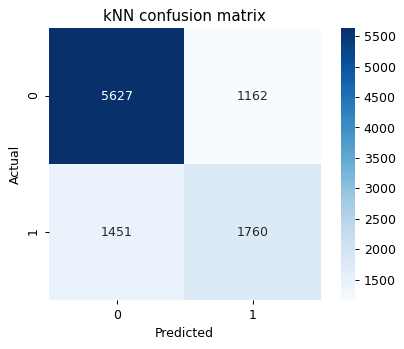

In [18]:
knn_confusion = confusion_matrix(ys_test, knn.predict(Zs_test))
plt.figure(dpi=90)
sns.heatmap(knn_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('kNN confusion matrix');

In [19]:
# from imblearn.under_sampling import CondensedNearestNeighbour


# cnn = CondensedNearestNeighbour()

# # X_resampled, y_resampled = cnn.fit_resample(X, y)
# # Xs_resampled, ys_resampled = cnn.fit_resample(Xs, ys)
# # Z_resampled, y_resampled = cnn.fit_resample(Z, y)
# Zs_resampled, ys_resampled = cnn.fit_resample(Zs, ys)

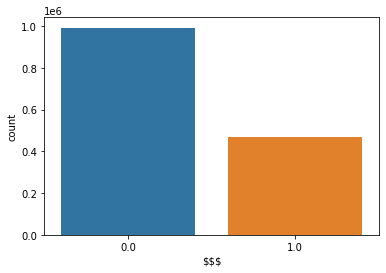

In [20]:
sns.countplot(train_df['$$$'])

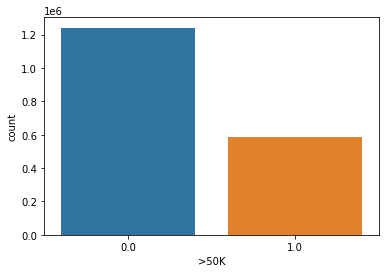

In [21]:
sns.countplot(y['>50K'])

#### Slightly unbalanced -- try undersampling. We don't want random undersampling - Condensed Nearest Neighbor looks good!

In [22]:
# sns.countplot(y_resampled['>50K'])

In [23]:
logit = LogisticRegression(C = 0.95)
logit.fit(Xs_train, ys_train)
print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*logit.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*logit.score(X_test, y_test)))

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


The score for logistic regression is
Training:  68.97%
Test set:  69.02%


/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [24]:
# logit = LogisticRegression(C = 0.95)
# logit.fit(Xs_resampled, ys_resampled)
# print("The score for logistic regression is")
# print("Training: {:6.2f}%".format(100*logit.score(Xs_resampled, ys_resampled)))
# print("Test set: {:6.2f}%".format(100*logit.score(X_test, y_test)))

In [25]:
# using the default threshold of 0.5, which is what vanilla predict does
ys_predict = knn.predict(Zs_test)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(ys_test, ys_predict), 
                                                     recall_score(ys_test, ys_predict)))

Default threshold:
Precision: 0.6023,   Recall: 0.5481


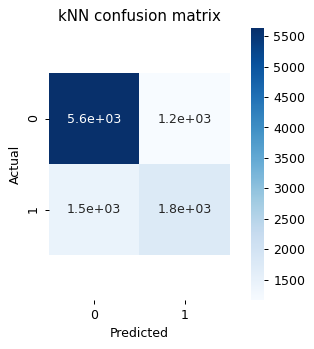

In [26]:
knn_confusion = confusion_matrix(ys_test, knn.predict(Zs_test))
fig, ax = plt.subplots(dpi=90)
#plt.figure()
sns.heatmap(knn_confusion, cmap=plt.cm.Blues, annot=True, square=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('kNN confusion matrix');

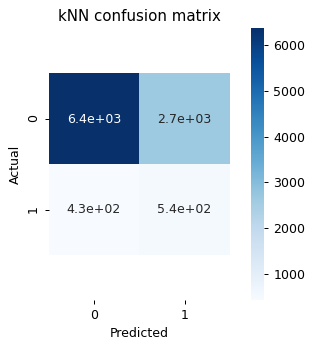

In [27]:
knn_confusion = confusion_matrix(logit.predict(Xs_test), ys_test)
fig, ax = plt.subplots(dpi=90)
sns.heatmap(knn_confusion, cmap=plt.cm.Blues, annot=True, square=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('kNN confusion matrix');

In [28]:
fbeta_score(ys_test, ys_predict, average=None, beta=0.5)

array([0.80154412, 0.59064367])

In [29]:
logit.coef_

array([[ 1.09382468e-06, -4.70998836e-05,  4.06934955e-08,
         1.25429472e-07,  4.36723468e-07,  1.51259864e-05,
         9.33610081e-07, -4.95265996e-07,  5.55498123e-05,
         2.55522255e-07,  7.17837221e-07,  1.71565044e-05,
        -8.36162083e-06,  2.52280428e-06,  1.11675454e-05,
         6.24529362e-09,  3.83348011e-05, -3.00117033e-05,
        -5.48091635e-09, -2.59587178e-05, -3.46431974e-08,
        -1.18478385e-05, -4.96703009e-08, -8.64467838e-07,
        -3.31974089e-05, -6.49358178e-07, -9.46014599e-08,
        -4.27800718e-06,  1.67326900e-09,  1.51159667e-06,
        -2.75833862e-08,  2.71059189e-07,  3.97536210e-08,
        -5.74468185e-05,  1.00972880e-05,  3.30506713e-07,
        -7.22962041e-08,  2.24424815e-07, -7.98883503e-10,
        -4.46748678e-07,  1.21724021e-08, -6.43646982e-08,
        -1.75734994e-06, -4.34847113e-08]])

In [30]:
X.columns

Index(['UHRSWORK', 'OCC', 'EDUC', 'WKSWORK2', 'VALUEH', 'OWNCOST', 'DEGFIELD',
       'AGE', 'PWPUMA00', 'PROPTX99', 'TRANTIME', 'MORTAMT1', 'DENSITY',
       'PROPINSR', 'ARRIVES', 'METPOP10', 'IND', 'PUMA', 'HIUID', 'COSTELEC',
       'SEX', 'ANCESTR1', 'ROOMS', 'BPL', 'COSTWATR', 'STATEICP', 'RELATE',
       'MET2013', 'STATEFIP', 'PWCOUNTY', 'BUILTYR2', 'COUNTYFIP', 'MOVEDIN',
       'COSTGAS', 'DEPARTS', 'TRANWORK', 'EMPSTAT', 'CLASSWKRD', 'WRKLSTWK',
       'REGION', 'WORKEDYR', 'CBPERNUM', 'YNGCH', 'BEDROOMS'],
      dtype='object')

In [31]:
Z.columns

Index(['EDUC', 'UHRSWORK', 'OCC', 'VALUEH', 'DEGFIELD', 'AGE', 'SEX',
       'TRANWORK'],
      dtype='object')

Looks like UHRSWORK and EDUC are the main indicators. Let's see for UHRSWORK how accurate of a prediction we get

In [108]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(Zs_train, ys_train)
print("The score for kNN is")
print("Training: {:6.2f}%".format(100*knn.score(Zs_train, ys_train)))
print("Test set: {:6.2f}%".format(100*knn.score(Zs_test, ys_test)))

<ipython-input-108-53aecb45cfcd>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Zs_train, ys_train)


The score for kNN is
Training:  78.36%
Test set:  74.52%


Simple logistic regression looking the best! Below. Highest r2 on test data yet!

In [33]:
logit = LogisticRegression(C = 0.95)
logit.fit(Zs_train, ys_train)
print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*logit.score(Zs_train, ys_train)))
print("Test set: {:6.2f}%".format(100*logit.score(Zs_test, ys_test)))

The score for logistic regression is
Training:  75.80%
Test set:  75.56%


/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Yikes... with scaling the test r2 goes down to 32%!! Why?

In [34]:
logit = LogisticRegression(C = 0.95)
logit.fit(Zs_train_scaled, ys_train)
print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*logit.score(Zs_train_scaled, ys_train)))
print("Test set: {:6.2f}%".format(100*logit.score(Zs_test, ys_test)))

The score for logistic regression is
Training:  80.17%
Test set:  32.48%


/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


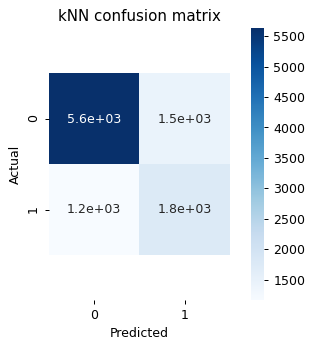

In [35]:
knn_confusion = confusion_matrix(knn.predict(Zs_test), ys_test)
fig, ax = plt.subplots(dpi=90)
#plt.figure(dpi=90)
sns.heatmap(knn_confusion, cmap=plt.cm.Blues, annot=True, square=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('kNN confusion matrix');

In [36]:
ys_predict = knn.predict(Zs_test)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(ys_test, ys_predict), 
                                                     recall_score(ys_test, ys_predict)))

Default threshold:
Precision: 0.6023,   Recall: 0.5481


In [37]:
logit.coef_

array([[ 0.77553029,  1.45192184, -0.34595685,  0.23256544,  0.05569495,
         0.73942339, -0.48090653,  0.03615899]])

<img src=https://newbiettn.github.io/images/confusion-matrix-noted.jpg width="250">

In [38]:
train_df.head()

,UHRSWORK,OCC,EDUC,WKSWORK2,VALUEH,OWNCOST,DEGFIELD,AGE,PWPUMA00,PROPTX99,...,TRANWORK,EMPSTAT,CLASSWKRD,WRKLSTWK,REGION,WORKEDYR,CBPERNUM,YNGCH,BEDROOMS,$$$
1971391,0.0,0.0,4.0,0.0,80000.0,228.0,0.0,16.0,0.0,22.0,...,0.0,3.0,0.0,1.0,12.0,1.0,3.0,99.0,6.0,0.0
2804169,45.0,7220.0,6.0,6.0,100000.0,1148.0,0.0,56.0,3800.0,32.0,...,10.0,1.0,22.0,2.0,33.0,3.0,1.0,31.0,5.0,1.0
62430,0.0,0.0,11.0,0.0,2387000.0,1087.0,23.0,78.0,0.0,65.0,...,0.0,3.0,0.0,1.0,41.0,1.0,2.0,99.0,4.0,1.0
1226121,40.0,5240.0,6.0,6.0,1100.0,698.0,0.0,55.0,500.0,54.0,...,10.0,1.0,23.0,2.0,22.0,3.0,1.0,99.0,4.0,0.0
2131220,0.0,0.0,10.0,0.0,370000.0,561.0,23.0,71.0,0.0,27.0,...,0.0,3.0,0.0,1.0,31.0,1.0,2.0,99.0,5.0,0.0


# **MODELS**

### KNN with small feature set

In [96]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(Zs_train, qs_train)
print("The score for kNN is")
print("Training: {:6.2f}%".format(100*knn.score(Zs_train, qs_train)))
print("Test set: {:6.2f}%".format(100*knn.score(Zs_test, qs_test)))

<ipython-input-96-be8dd8461117>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Zs_train, qs_train)


The score for kNN is
Training:  81.91%
Test set:  73.87%


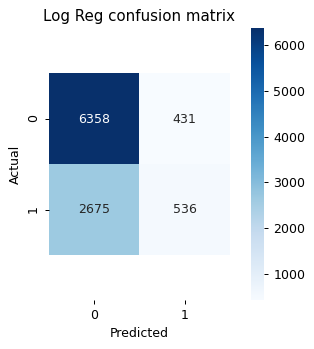

In [97]:
knn_confusion = confusion_matrix(knn.predict(Zs_test), qs_test)
fig, ax = plt.subplots(dpi=90)
#plt.figure(dpi=90)
sns.heatmap(logit_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Log Reg confusion matrix');

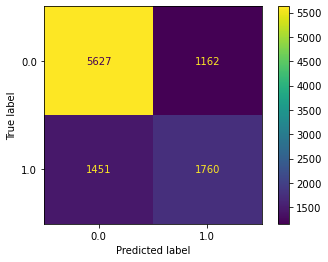

In [98]:
plot_confusion_matrix(knn, Zs_test, qs_test)

### KNN with full feature set

In [89]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(Xs_train, ys_train)
print("The score for kNN is")
print("Training: {:6.2f}%".format(100*knn.score(Xs_train, ys_train)))
print("Test set: {:6.2f}%".format(100*knn.score(Xs_test, ys_test)))

<ipython-input-89-07a8951d040d>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Xs_train, ys_train)


The score for kNN is
Training:  75.75%
Test set:  64.41%


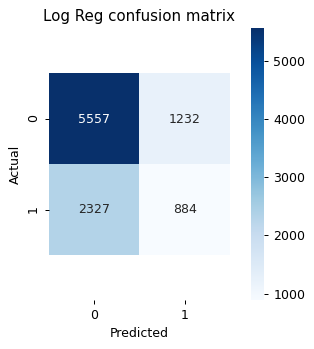

In [94]:
knn_confusion = confusion_matrix(ys_test, knn.predict(Xs_test))
fig, ax = plt.subplots(dpi=90)
#plt.figure(dpi=90)
sns.heatmap(knn_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Log Reg confusion matrix');

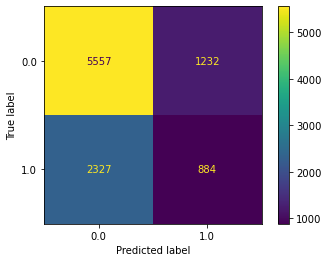

In [95]:
plot_confusion_matrix(knn, Xs_test, ys_test)

### Logistic Regression with Small Feature set

In [114]:
logit = LogisticRegression(C = 1, penalty='l2')
logit.fit(Zs_train, qs_train)
print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*logit.score(Zs_train, qs_train)))
print("Test set: {:6.2f}%".format(100*logit.score(Zs_test, qs_test)))

The score for logistic regression is
Training:  75.80%
Test set:  75.56%


/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


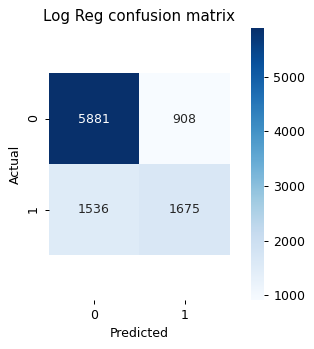

In [85]:
logit_confusion = confusion_matrix(qs_test, logit.predict(Zs_test))
fig, ax = plt.subplots(dpi=90)
#plt.figure(dpi=90)
sns.heatmap(logit_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Log Reg confusion matrix');

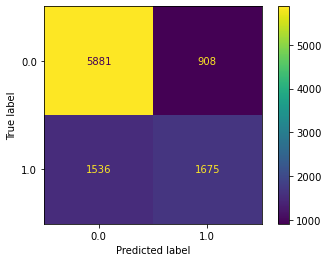

In [84]:
plot_confusion_matrix(logit, Zs_test, qs_test)

In [71]:
qs_predict = logit.predict(Zs_test)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(qs_test, qs_predict), 
                                                     recall_score(qs_test, qs_predict)))

Default threshold:
Precision: 0.6485,   Recall: 0.5216


### Logistic Regression with Full Feature Set

In [115]:
logit = LogisticRegression(C = 1, penalty='l2')
logit.fit(Xs_train, ys_train)
print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*logit.score(Xs_train, ys_train)))
print("Test set: {:6.2f}%".format(100*logit.score(Xs_test, ys_test)))

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The score for logistic regression is
Training:  69.04%
Test set:  68.94%


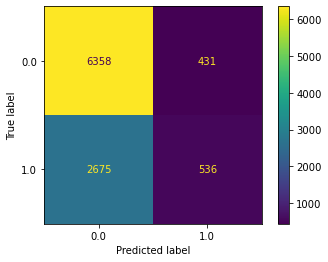

In [87]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(logit, Xs_test, ys_test)

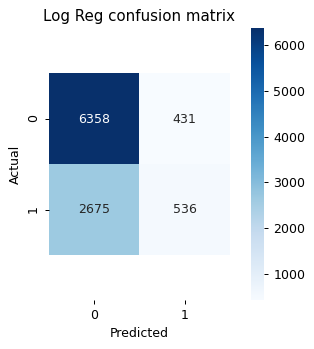

In [88]:
logit_confusion = confusion_matrix(ys_test, logit.predict(Xs_test))
fig, ax = plt.subplots(dpi=90)
#plt.figure(dpi=90)
sns.heatmap(logit_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Log Reg confusion matrix');

In [66]:
ys_predict = logit.predict(Xs_test)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(ys_test, ys_predict), 
                                                     recall_score(ys_test, ys_predict)))

Default threshold:
Precision: 0.5543,   Recall: 0.1669


In [72]:
logit.coef_

array([[-8.44976653e-04,  3.11267304e-02, -2.15991832e-04,
         5.65870684e-08,  2.01598350e-02, -2.30537293e-02,
        -1.52844915e-03,  8.50231838e-03]])

In [73]:
Zs_train.columns

Index(['EDUC', 'UHRSWORK', 'OCC', 'VALUEH', 'DEGFIELD', 'AGE', 'SEX',
       'TRANWORK'],
      dtype='object')

In [ ]:
with open('/home/nick/Documents/data/select_cols.p', 'rb') as read_file:
    selected_columns = pickle.load(read_file)

tw = selected_columns.sample(50000)
ttw = selected_columns.sample(1000)
tttw = selected_columns.sample(50)

X, Xs, y, ys, Z, Zs = selected_columns.drop(columns=['>50K', 'YRMARR', 'PWTYPE', 'BPLD', 'DEGFIELDD', 'EDUCD', 'PWMET13', 'BIRTHYR', 'SLWT', 'BPLD', 'RELATED', 'ANCESTR1D', 'EMPSTATD', 'PWMET13ERR', 'COUNTYICP']), tw.drop(columns=['>50K', 'YRMARR', 'PWTYPE', 'BPLD', 'DEGFIELDD', 'EDUCD', 'PWMET13', 'BIRTHYR', 'SLWT', 'BPLD', 'RELATED', 'ANCESTR1D', 'EMPSTATD', 'PWMET13ERR', 'COUNTYICP']), selected_columns.filter(['>50K']), tw.filter(['>50K']), selected_columns.filter(['EDUC', 'UHRSWORK', 'OCC', 'VALUEH', 'DEGFIELD', 'AGE', 'SEX', 'RACE', 'TRANWORK']), tw.filter(['EDUC', 'UHRSWORK', 'OCC', 'VALUEH', 'DEGFIELD', 'AGE', 'SEX', 'RACE', 'TRANWORK'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, test_size=0.2, random_state=42)
Z_train, Z_test, q_train, q_test = train_test_split(Z, y, test_size=0.2, random_state=42)
Zs_train, Zs_test, qs_train, qs_test = train_test_split(Zs, ys, test_size=0.2, random_state=42)

train_df = Zs_train.copy()
train_df['$$$'] = ys_train

std = StandardScaler()
X_train_scaled = std.fit_transform(X_train)
Xs_train_scaled = std.fit_transform(Xs_train)
Z_train_scaled = std.fit_transform(Z_train)
Zs_train_scaled = std.fit_transform(Zs_train)

**Near Miss Undersampling**

In [74]:
from imblearn.under_sampling import NearMiss

nm1 = NearMiss(version=1)

# models(Z_train, y_train, NearMiss)

<a class="anchor" id="gridsearch"></a>
## Grid Search CV

**Logistic Regression**, small feature set

In [75]:
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)
logreg = LogisticRegression()
clf = GridSearchCV(logreg, hyperparameters, cv=5, verbose=0)
best_model = clf.fit(Zs_train, qs_train)    
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/nick/anaconda3/lib/python3.8/site-packa

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise Va

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise Va

Best Penalty: l2
Best C: 1.0


/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


**Logistic Regression**, full feature set

In [ ]:
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)
logreg = LogisticRegression()
clf = GridSearchCV(logreg, hyperparameters, cv=5, verbose=0)
best_model = clf.fit(Xs_train, ys_train)    
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

#### Bonus: KNN with undersampled data

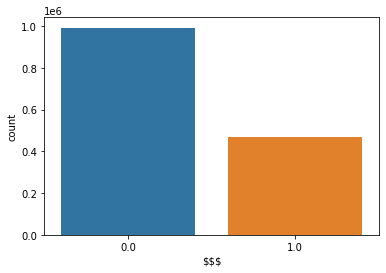

In [117]:
sns.countplot(train_df['$$$'])

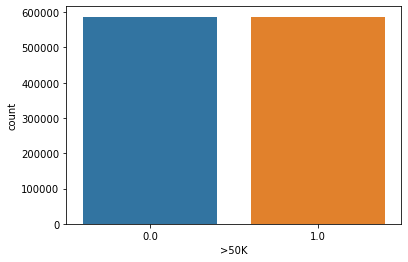

In [118]:
nm1 = NearMiss(version=1, sampling_strategy='majority', n_jobs=-1)
Zr, yr = nm1.fit_resample(Z, y)
Zsr, qr = nm1.fit_resample(Zs, ys)
sns.countplot(yr['>50K'])

In [119]:
Zsr_train, Zsr_test, qr_train, qr_test = train_test_split(Zsr, qr, test_size=0.2, random_state=42)

In [120]:
knn = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)
knn.fit(Zsr_train, qr_train)
print("Training: {:6.2f}%".format(100*knn.score(Zsr_train, qr_train)))
print("Test set: {:6.2f}%".format(100*knn.score(Zs_test, qs_test)))

<ipython-input-120-e7f26b896490>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(Zsr_train, qr_train)


Training:  81.25%
Test set:  62.09%
